# Theoretical Phase Changes in 1 Neuron Models

In [5]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm
import warnings
from torch import nn

In [322]:
def l1(s):
  return (s/3) - (s*s)/4

def l2(s, r):
  return r * ((s/3) - (s*s)/4)

def l3(s, r):
  return ((1 + r) * s*s) / 6

# Create a tensor
rv = torch.zeros(1000, 100)

# Create grids
i, j = torch.meshgrid(torch.arange(1000), torch.arange(100), indexing='ij')

# Calculate s and r for the entire grid
s = (i) / 1000
r = j / 10

# Apply the functions
l1_result = l1(s)
l2_result = l2(s, r)
l3_result = l3(s, r)

# Apply the custom min logic
condition1 = torch.le(l1_result, l2_result) & torch.le(l1_result, l3_result)
condition2 = torch.le(l2_result, l1_result) & torch.le(l2_result, l3_result)

rv[condition1] = -1
rv[condition2] = 1
rv[~condition1 & ~condition2] = 0

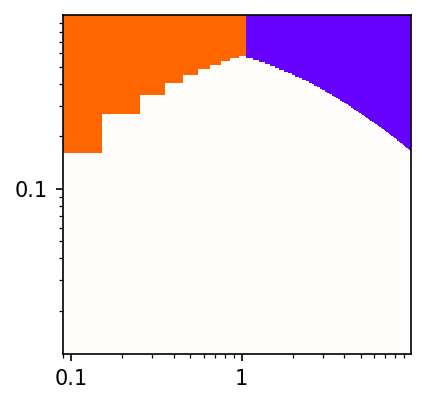

In [330]:
warnings.filterwarnings('ignore')

plt.figure(figsize=(3, 3), dpi=150)

# Set the x-axis to a logarithmic scale
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

colors = [(.4, 0, 1), (1, 1, 1), (1, .4, 0)]  # Purple -> White -> Orange
n_bins = 100 
cm = LinearSegmentedColormap.from_list("", colors, N=n_bins)

plt.imshow(rv, cmap=cm, aspect='auto')

# Get current y-ticks
current_yticks = plt.gca().get_yticks()

plt.gca().invert_yaxis()
plt.gca().set_xticklabels(['', '', '0.1', '1', '10', '', ''])
plt.gca().set_yticklabels(['', '', '0.1', '0.1', ''])

plt.show()

# Proof of concept 1 Neuron Model

In [331]:
def get_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

device = get_device()
print(f"Using {device} device")

Using mps device


In [13]:
# !!! SIMILAR CODE FROM "demonstrating_superposition.ipynb" !!! #

class ToyModel(nn.Module):
    def __init__(self, m, n, include_ReLU):
        '''Create a toy model

        Args:
            m (int): the number of neurons (as described in original paper)
            n (int): the number of features the Toy model can map.
            (The weight matrix is delcared to be m * n)

            include_ReLU (bool): if True, a nonlinearity is added to the network
        '''
        super().__init__()
        self.weights = nn.Parameter(torch.randn(m, n), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(n, 1), requires_grad=True)
        self.ReLU = nn.ReLU(inplace=True)
        self.inclue_ReLU = include_ReLU
        
    def forward(self, x):
        hidden = self.weights @ x
        final = self.weights.T @ hidden
        final += self.bias
        if self.inclue_ReLU:
            return self.ReLU(final)
        else:
            return final

class ImporanceWeightedMSE(nn.Module):
    def __init__(self):
        super(ImporanceWeightedMSE, self).__init__()

    def forward(self, predictions, targets, importance):
        sub_total = ((predictions - targets)**2).sum(0).flatten()
        return sum(sub_total * importance)

In [22]:
# !!! SIMILAR CODE FROM "demonstrating_superposition.ipynb" !!! #

def train(model, epochs, total_batchs, batch_size, loss_fn, optimizer, importance, sparsity):
    probability = 1 - sparsity
    model.train()
    loss_total = 0
    for epoch in range(epochs):
        for i in range(total_batchs):
            sparsity_tensor = torch.bernoulli(torch.full((2,1), probability))
            x = torch.rand(batch_size, 2, 1)
            x = (x*sparsity_tensor).to(device)
            pred = model(x)
            loss = loss_fn(pred, x, importance)
            loss_total += loss.item()
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print("(EPOCH:", str(epoch + 1) + ")", "--> loss:", loss_total / (total_batchs * batch_size))
        loss_total = 0

In [97]:
NUM_EPOCHS = 5
BATCHS_PER_EPOCH = 1000
BATCH_SIZE = 512
LEARNING_RATE = 5e-3
IMPORTANCE = (0.01 ** torch.arange(0, 2)).to(device)

In [98]:
model_99_sparsity = ToyModel(1, 2, False).to(device)

In [99]:
SPARSITY = 0.0
optimizer = torch.optim.Adam(model_99_sparsity.parameters(), lr=LEARNING_RATE)
loss_func = ImporanceWeightedMSE()

train(model_99_sparsity, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 1.526354720722884
(EPOCH: 2) --> loss: 0.0292441052114591
(EPOCH: 3) --> loss: 0.009354934247909114
(EPOCH: 4) --> loss: 0.0020913388857152315
(EPOCH: 5) --> loss: 0.0008785506336716935


In [100]:
model_99_sparsity.weights

Parameter containing:
tensor([[ 0.9991, -0.0034]], device='mps:0', requires_grad=True)

In [101]:
model_99_sparsity.bias

Parameter containing:
tensor([[0.0027],
        [0.5011]], device='mps:0', requires_grad=True)

# Training 1 Neuron Models

In [267]:
class ManyToyModels(nn.Module):
    def __init__(self, m, n, num_models, include_ReLU):
        '''Create a toy model

        Args:
            m (int): the number of neurons (as described in original paper)
            n (int): the number of features the Toy model can map.
            (The weight matrix is delcared to be m * n)

            include_ReLU (bool): if True, a nonlinearity is added to the network
        '''
        super().__init__()
        self.weights = nn.Parameter(torch.randn(num_models, m, n), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(num_models, n, 1), requires_grad=True)
        self.ReLU = nn.ReLU(inplace=True)
        self.inclue_ReLU = include_ReLU
        
    def forward(self, x):
        hidden = self.weights @ x
        final = torch.transpose(self.weights, -2, -1) @ hidden
        final += self.bias
        if self.inclue_ReLU:
            return self.ReLU(final)
        else:
            return final

class MSE_Multiple_models(nn.Module):
    def __init__(self):
        super(MSE_Multiple_models, self).__init__()

    def forward(self, predictions, targets, importance):
        sub_total = ((predictions - targets)**2).sum(0)
        return torch.sum(sub_total * importance)

In [363]:
def train_1000_models(model, num_models, epochs, total_batchs, batch_size, loss_fn, optimizer, importance, sparsity):
    probability = 1 - sparsity
    model.train()
    loss_total = 0
    for epoch in range(epochs):
        for i in range(total_batchs):
            sparsity_tensor = torch.bernoulli(torch.full((2 ,1), probability))
            x = torch.rand(batch_size, num_models, 2, 1)
            x = (x*sparsity_tensor).to(device)
            pred = model(x)
            loss = loss_fn(pred, x, importance)
            loss_total += loss.item()
    
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print("(EPOCH:", str(epoch + 1) + ")", "--> loss:", loss_total / (total_batchs * batch_size))
        loss_total = 0

In [370]:
model_test = ManyToyModels(1, 2, 100000, False).to(device)

In [371]:
# model_test(torch.randn(1, 10, 2, 1).to(device))

In [378]:
NUM_EPOCHS = 20
BATCHS_PER_EPOCH = 100
BATCH_SIZE = 16
LEARNING_RATE = 5e-3

In [379]:
first_feature_importance = torch.ones(100000, 1)
second_feature_importance = (torch.repeat_interleave(torch.arange(100), 1000) / 10).reshape(100000, 1)
IMPORTANCE = torch.stack((first_feature_importance, second_feature_importance), dim=1).to(device)

In [380]:
SPARSITY = 0.0
optimizer = torch.optim.Adam(model_test.parameters(), lr=LEARNING_RATE)
loss_func = MSE_Multiple_models()
num_models = 100000

train_1000_models(model_test, num_models, NUM_EPOCHS, BATCHS_PER_EPOCH, BATCH_SIZE, loss_func, optimizer, IMPORTANCE, SPARSITY)

(EPOCH: 1) --> loss: 25152.643125
(EPOCH: 2) --> loss: 15994.9673828125
(EPOCH: 3) --> loss: 12356.544306640624
(EPOCH: 4) --> loss: 10536.60732421875
(EPOCH: 5) --> loss: 9547.62083984375
(EPOCH: 6) --> loss: 8963.6928515625
(EPOCH: 7) --> loss: 8597.260400390625
(EPOCH: 8) --> loss: 8364.539130859375
(EPOCH: 9) --> loss: 8217.306850585937
(EPOCH: 10) --> loss: 8119.491166992188
(EPOCH: 11) --> loss: 8057.835107421875
(EPOCH: 12) --> loss: 8015.707998046875
(EPOCH: 13) --> loss: 7986.529350585937
(EPOCH: 14) --> loss: 7966.891865234375
(EPOCH: 15) --> loss: 7951.86802734375
(EPOCH: 16) --> loss: 7942.048310546875
(EPOCH: 17) --> loss: 7932.562124023438
(EPOCH: 18) --> loss: 7926.081518554687
(EPOCH: 19) --> loss: 7922.313188476563
(EPOCH: 20) --> loss: 7917.801254882813


In [381]:
model_test.weights

Parameter containing:
tensor([[[-1.0000e+00, -2.0149e-10]],

        [[ 1.0000e+00,  4.2285e-08]],

        [[ 1.0000e+00, -8.7737e-12]],

        ...,

        [[ 6.4922e-03, -9.9975e-01]],

        [[-3.8078e-03, -1.0016e+00]],

        [[-5.0459e-03,  1.0027e+00]]], device='mps:0', requires_grad=True)